In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plot_jordi

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

# -------------- CONVERSION TABLE ----------------------------------------------------------

In [3]:
conversion_df = pd.read_csv('data/grade.csv')
conversion_df = conversion_df[['id','fra_routes']]
conversion_df.reset_index(inplace = True)
conversion_df

,index,id,fra_routes
0,0,1,-
1,1,2,1
2,2,3,1a
3,3,4,1b
4,4,5,1c
...,...,...,...
78,78,82,9b+/9c
79,79,83,9c
80,80,84,9c/+
81,81,85,9c+


In [4]:
# We see that we have a problme here: the id is not consecutive so we cannot calculate metrics like mean..
# We will transform the "id" into the "index" for each grade_id on the ascent table with this function
def evaluate(x):
    if x < 48:
        x-1
    elif x < 61:
        x-2
    elif x < 74:
        x-3
    else:
        x-4
    return x

def Correct_grade_id(df):
    df['grade_id'] = df['grade_id'].apply(lambda x: evaluate(x))
    return df

# -------------- USER TABLE ----------------------------------------------------------

In [5]:
grades_df = pd.read_csv('data/user.csv')
grad = grades_df.copy()
grad = grad.rename(columns={'id':'user_id'}) 
grad.head()

<ipython-input-5-f84eeabca033>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  grades_df = pd.read_csv('data/user.csv')


,user_id,first_name,last_name,city,country,sex,height,weight,started,competitions,occupation,sponsor1,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
0,1,first,last,Göteborg,SWE,0,177,73,1996,NaN,NaN,NaN,NaN,NaN,"Railay beach, Krabi, Thailand",NaN,NaN,NaN,1976-03-10,NaN,0,0
1,2,first,last,stockholm,SWE,0,0,0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,first,last,Umeå,SWE,0,180,78,1995,NaN,NaN,NaN,NaN,NaN,Hell,Umeå,NaN,NaN,1973-09-09,NaN,0,0
3,4,first,last,Goteborg,SWE,1,165,58,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984-07-26,NaN,0,0
4,5,first,last,North Attleboro,USA,0,0,0,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-05-07,NaN,0,0


In [6]:
# We have to clean first the NA numbers
pd.set_option('display.max_rows', None)
display(grad.isna().sum()/len(grad))
grad.shape
pd.set_option('display.max_rows', 10)

user_id         0.000000
first_name      0.000000
last_name       0.000000
city            0.022846
country         0.001566
sex             0.000000
height          0.000000
weight          0.000000
started         0.000000
competitions    0.921908
occupation      0.811832
sponsor1        0.914447
sponsor2        0.957567
sponsor3        0.976084
best_area       0.753758
worst_area      0.996485
guide_area      0.876104
interests       0.862972
birth           0.554966
presentation    0.902337
deactivated     0.000000
anonymous       0.000000
dtype: float64

In [7]:
# If we fill the NA's of "" with the mode..
grad['country'] = grad['country'].fillna(grad['country'].mode()[0])

In [8]:
grad_clean = grad.drop(columns=['city','first_name','last_name','competitions','occupation','sponsor1','sponsor2','sponsor3','best_area','worst_area','guide_area','interests','presentation','deactivated','anonymous'])
# I think birth is a really important feature
# grad_clean = grad_clean.drop(columns=['birth'])
# grad_clean = grad_clean.dropna()
print(grad_clean.isna().sum())
grad_clean.shape

user_id        0
country        0
sex            0
height         0
weight         0
started        0
birth      34737
dtype: int64


(62593, 7)

In [9]:
def Lower_fun(x):
    if ~pd.isna(x) & isinstance(x, str):
        x.lower()
    elif ~isinstance(x, str):
        x = float("NAN")  
    return x

def Birth_fun(x):
    if ~pd.isna(x) & isinstance(x, str):
        x = float(x[0:4])
    else:
        x = float("NAN")  
    return x

# grad_clean['city'] = grad_clean['city'].apply(Lower_fun)
grad_clean['birth'] = grad_clean['birth'].apply(Birth_fun)

In [10]:
print(grad_clean.isna().sum())
grad_clean.shape

user_id        0
country        0
sex            0
height         0
weight         0
started        0
birth      34737
dtype: int64


(62593, 7)

In [11]:
grad_clean

,user_id,country,sex,height,weight,started,birth
0,1,SWE,0,177,73,1996,1976.0
1,2,SWE,0,0,0,2000,NaN
2,3,SWE,0,180,78,1995,1973.0
3,4,SWE,1,165,58,2001,1984.0
4,5,USA,0,0,0,1991,1969.0
...,...,...,...,...,...,...,...
62588,67021,ESP,0,180,78,0,1991.0
62589,67022,FRA,0,185,68,2016,1989.0
62590,67023,USA,0,190,88,2001,1986.0
62591,67024,POL,1,0,0,0,NaN


In [12]:
# Clean countries with not so many people climbing
# print(grad_clean.shape)
# countries = np.array(grad_clean['country'].value_counts().head(20).index)
# grad_clean = grad_clean[grad_clean.country.isin(countries)]
# display(grad_clean)
# print(grad_clean.shape)

In [13]:
# group the countries in "others"
countries = np.array(grad_clean['country'].value_counts().head(35).index)
grad_clean['country'] = grad_clean['country'].apply(lambda x: "other" if (x not in countries) else x)
grad_clean['country'].value_counts()

USA    11959
ESP     6905
DEU     3712
SWE     3629
ITA     3590
       ...  
HUN      262
TUR      211
ARG      208
IRN      189
JPN      182
Name: country, Length: 36, dtype: int64

In [14]:
# Cleaning...
# When the value is 0 we have to replace it with the mean

Before:  (62593, 7)  and after:  (22297, 7)


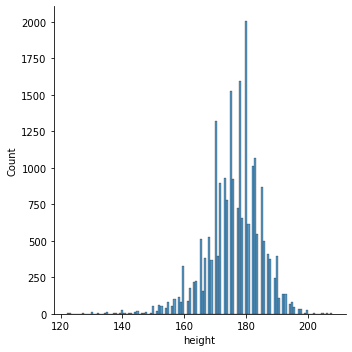

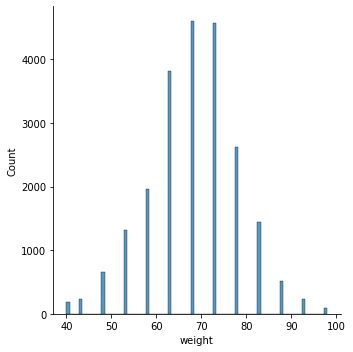

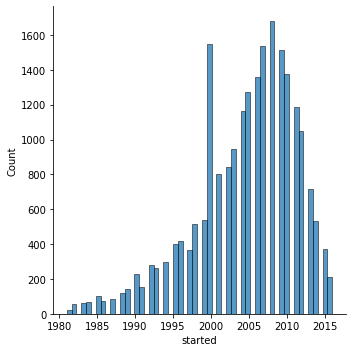

In [15]:
# Remove outliners of started
grad_clean2 = grad_clean[grad_clean.started < 2017]
grad_clean2 = grad_clean2[grad_clean2.started > 1980]
# Remove outliners of heigh below 120 or above 210
grad_clean2 = grad_clean2[grad_clean2.height > 120]
grad_clean2 = grad_clean2[grad_clean2.height < 210]
# Remove outliners of weight
grad_clean2 = grad_clean2[grad_clean2.weight > 20]
grad_clean2 = grad_clean2[grad_clean2.weight < 100]
grad_clean2.reset_index(inplace = True, drop = True)
sns.displot(grad_clean2.height, palette="Set1")
sns.displot(grad_clean2.weight, palette="Set1")
sns.displot(grad_clean2.started, palette="Set1")
print("Before: ",grad_clean.shape, " and after: ",grad_clean2.shape)

In [16]:
grad_clean2.shape

(22297, 7)

In [17]:
# We can separate men and women:
grad_clean2.sex.value_counts()
grad_men = grad_clean2[grad_clean2.sex == 0]
grad_women = grad_clean2[grad_clean2.sex == 1]

In [18]:
print("The mean height of climber men is: ", np.mean(grad_men.height))
print("The sdev height of climber men is: ", np.std(grad_men.height))
print("The mean height of climber women is: ", np.mean(grad_women.height))
print("The sdev height of climber women is: ", np.std(grad_women.height))

The mean height of climber men is:  177.8602646656188
The sdev height of climber men is:  7.658365011728315
The mean height of climber women is:  164.45104895104896
The sdev height of climber women is:  7.818436267895804


,user_id,sex,height,weight,started,birth
user_id,1.000000,0.055137,-0.054969,-0.049651,0.591763,0.340456
sex,0.055137,1.000000,-0.487377,-0.499614,0.081700,0.046100
height,-0.054969,-0.487377,1.000000,0.711445,-0.047970,-0.116139
weight,-0.049651,-0.499614,0.711445,1.000000,-0.074544,-0.220248
started,0.591763,0.081700,-0.047970,-0.074544,1.000000,0.504269
birth,0.340456,0.046100,-0.116139,-0.220248,0.504269,1.000000


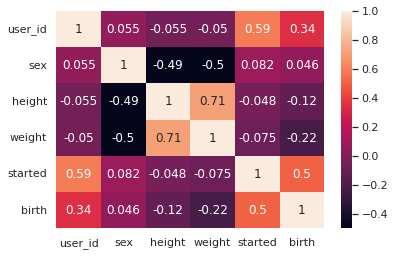

In [19]:
sns.set(rc={'figure.figsize':(6,4)})
correlations_matrix = grad_clean2.corr()
display(correlations_matrix)
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [20]:
print(grad_clean2.shape)
grad_clean2

(22297, 7)


,user_id,country,sex,height,weight,started,birth
0,1,SWE,0,177,73,1996,1976.0
1,3,SWE,0,180,78,1995,1973.0
2,4,SWE,1,165,58,2001,1984.0
3,6,AUS,0,185,73,1992,1970.0
4,10,SWE,0,167,63,1992,1965.0
...,...,...,...,...,...,...,...
22292,67015,ESP,1,145,40,2009,2009.0
22293,67019,NOR,0,172,73,2013,1991.0
22294,67020,DEU,0,178,78,2005,1993.0
22295,67022,FRA,0,185,68,2016,1989.0


In [21]:
# Replace columns
grad_clean2['age'] = 2017 - grad_clean2['birth']
grad_clean2['years_cl'] = 2017 - grad_clean2['started']
grad_clean2 = grad_clean2.drop(columns = ['birth','started'])
grad_clean2

,user_id,country,sex,height,weight,age,years_cl
0,1,SWE,0,177,73,41.0,21
1,3,SWE,0,180,78,44.0,22
2,4,SWE,1,165,58,33.0,16
3,6,AUS,0,185,73,47.0,25
4,10,SWE,0,167,63,52.0,25
...,...,...,...,...,...,...,...
22292,67015,ESP,1,145,40,8.0,8
22293,67019,NOR,0,172,73,26.0,4
22294,67020,DEU,0,178,78,24.0,12
22295,67022,FRA,0,185,68,28.0,1


# -------------- ASCENT TABLE ----------------------------------------------------------

In [22]:
ascent_df = pd.read_csv('data/ascent.csv')
ascent = ascent_df.copy()
ascent

<ipython-input-22-89f9406d3794>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  ascent_df = pd.read_csv('data/ascent.csv')


,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,last_year,rec_date,project_ascent_date,name,crag_id,crag,sector_id,sector,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped
0,2,1,36,NaN,0,3,0,545,918342000,1999,0,1107126000,0,The King And I,16596,Railay,61,Dum's kitchen,THA,Thailand\n,0,NaN,255,0,0,0,0,0
1,3,1,36,NaN,0,3,0,545,925509600,1999,0,1107126000,0,vet ej,0,Nya berg - segl.,0,NaN,NaN,\n,0,NaN,0,0,0,0,0,0
2,4,1,36,NaN,0,3,0,545,933026400,1999,0,1107126000,0,Mr Big,209,Sjöända,371,Huvudväggen,SWE,\n,0,NaN,255,0,0,0,0,0
3,5,1,36,NaN,0,3,0,545,933026400,1999,0,1107126000,0,Tak ska du ha,209,Sjöända,371,Huvudväggen,SWE,\n,0,NaN,255,0,0,0,0,0
4,6,1,36,NaN,0,3,0,545,933458400,1999,0,1107126000,0,Korpen flyger,0,"Rankulla, Vetlanda",0,NaN,NaN,\n,0,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111872,4910370,59627,46,NaN,0,1,0,650,1505167200,2017,1,1505203912,0,Prawy Meningitis,28984,Dolina Bedkowska,102,Dupa Slonia,POL,"miała być rozgrzewka, a w pełnym słońcu był ca...",2,NaN,255,0,0,0,0,0
4111873,4910371,44075,49,NaN,0,1,0,700,1505080800,2017,1,1505204131,0,"Przyczajony Kucyk, Ukryty Smok",29014,Dolina Kluczwody,1623,Jaskinia Mamutowa,POL,NaN,0,NaN,255,0,0,0,0,0
4111874,4910376,19098,51,NaN,0,3,0,895,1504994400,2017,1,1505204598,0,Le cri du papillon,867,Mont Dauphin,2244,El Pouding,FRA,"Sobada, al igual que el 7b, 7c i l'altre 7c de...",0,NaN,255,0,0,0,0,0
4111875,4910379,19098,57,NaN,0,3,0,1045,1505080800,2017,1,1505205012,0,Central street,28033,Rue des masques,413,Le Canyon,FRA,"El 7a és guarrillu, però la part de dalt és bo...",2,NaN,255,0,0,0,0,0


In [23]:
# We have to clean first the NA numbers
print("Before cleaning the table\n",ascent.isna().sum())
print(ascent.shape)
ascent_clean = ascent.copy()
ascent_clean = ascent_clean[ascent_clean['climb_type'] == 0]
ascent_clean = ascent_clean.drop(columns=['climb_type','raw_notes','description','sector','sector_id','crag','country','exclude_from_ranking'])
ascent_clean.comment = ascent_clean.comment.fillna('?')
ascent_clean.dropna(inplace = True)
ascent_clean = ascent_clean.reset_index(drop = True)
print("\n\nAfter cleaning the table\n",ascent_clean.isna().sum())
print(ascent_clean.shape)

Before cleaning the table
 id                            0
user_id                       0
grade_id                      0
notes                   3084093
raw_notes                     0
                         ...   
climb_try                     0
repeat                        0
exclude_from_ranking          0
user_recommended              0
chipped                       0
Length: 28, dtype: int64
(4111877, 28)


After cleaning the table
 id                  0
user_id             0
grade_id            0
notes               0
method_id           0
                   ..
yellow_id           0
climb_try           0
repeat              0
user_recommended    0
chipped             0
Length: 20, dtype: int64
(730516, 20)


In [24]:
climber_grades = ascent_clean.copy()
climber_grades = climber_grades[['user_id','grade_id','date']]
climber_grades.head()

,user_id,grade_id,date
0,10,55,801957600
1,10,62,883609200
2,10,62,915145200
3,10,62,915145200
4,10,57,883609200


In [25]:
# We have to make the grade correction from the grades table because the grades should be consecutive.. 1,2,3..
climber_grades_correct = Correct_grade_id(climber_grades)
climber_grades_correct

,user_id,grade_id,date
0,10,55,801957600
1,10,62,883609200
2,10,62,915145200
3,10,62,915145200
4,10,57,883609200
...,...,...,...
730511,67020,21,1500069600
730512,67020,25,1500069600
730513,53784,36,1504562400
730514,53784,33,1504562400


In [26]:
climber_grades_correct
# your answer here
climber_grades_correct = climber_grades_correct.rename(columns={'grade_id':'grades'}) 
aggfunc_ ={'grades':['max','min','mean','count','sum','last','first'],'date':['max','min']}
climber_grades_met = climber_grades_correct.pivot_table(index= ['user_id'], values = ['grades','date'], aggfunc = aggfunc_ )
climber_grades_met.columns = ['_'.join(col) for col in climber_grades_met.columns.values] # jewell of the crown :)
climber_grades_met

,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum
user_id,,,,,,,,,
4,1240783200,1155765600,15,38,51,59,53.733333,38,806
10,1499724000,801957600,216,55,51,64,45.356481,7,9797
12,967759200,967759200,1,66,66,66,66.000000,66,66
15,1144879200,1140217200,3,66,68,68,64.333333,59,193
16,1351116000,979254000,24,62,62,64,51.875000,40,1245
...,...,...,...,...,...,...,...,...,...
67016,1504994400,1504994400,2,36,29,36,32.500000,29,65
67017,1504821600,1469311200,6,49,49,53,50.333333,49,302
67019,1502488800,1497477600,5,44,42,44,41.000000,31,205


In [27]:
# Filter grades:
climber_grades_met = climber_grades_met[climber_grades_met['grades_max'] > 28]
climber_grades_met = climber_grades_met[climber_grades_met['grades_max'] < 79]

In [28]:
# Defining intensityt
climber_grades_met['intensity'] = (climber_grades_met['date_max']-climber_grades_met['date_min'])/climber_grades_met['grades_count']
climber_grades_met.reset_index(inplace = True)
climber_grades_int = climber_grades_met.copy()
climber_grades_int = climber_grades_int[climber_grades_int['intensity'] > 0]
climber_grades_int['grades_mean'] = climber_grades_int['grades_mean'].apply(lambda x: round(x,2))
int_labeled = pd.qcut(climber_grades_int['intensity'], 4,
       labels=["LOW", "MEDIUM", "HIGH", "VERY HIGH"])
climber_grades_int['intensity_lab'] = int_labeled

In [29]:
# Defining highly suited
mean_mean = np.mean(climber_grades_int['grades_mean'])
climber_grades_int['suited'] = (climber_grades_int['grades_mean'] + climber_grades_int['grades_max'])/2
climber_grades_int['suited'] = climber_grades_int['suited'].apply(lambda x: round(x,2))
int_labeled = pd.qcut(climber_grades_int['intensity'], 3,
       labels=["NORMAL", "SUITED", "PRO"])
climber_grades_int['suited_lab'] = int_labeled
climber_grades_int

,user_id,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,intensity_lab,suited,suited_lab
0,4,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,HIGH,56.36,PRO
1,10,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,MEDIUM,54.68,SUITED
3,15,1144879200,1140217200,3,66,68,68,64.33,59,193,1.554000e+06,LOW,66.16,NORMAL
4,16,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,VERY HIGH,57.94,PRO
5,18,1335218400,1116453600,38,51,62,64,53.95,49,2050,5.756968e+06,HIGH,58.98,PRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21856,67009,1504044000,1495231200,2,51,51,51,51.00,51,102,4.406400e+06,HIGH,51.00,SUITED
21858,67017,1504821600,1469311200,6,49,49,53,50.33,49,302,5.918400e+06,HIGH,51.66,PRO
21859,67019,1502488800,1497477600,5,44,42,44,41.00,31,205,1.002240e+06,LOW,42.50,NORMAL
21860,67020,1500069600,1462831200,7,49,25,53,39.14,21,274,5.319771e+06,HIGH,46.07,SUITED


# -------------- We get concatenate ascent and users tables --------------------------

In [30]:
grad_clean_ind = grad_clean2.set_index('user_id')
climbers_gr_ind = climber_grades_int.set_index('user_id')
climber_df = pd.concat([grad_clean_ind,climbers_gr_ind],axis=1,join='inner')
climber_df.reset_index(inplace = True)
climber_df.shape

(10279, 20)

## Apply KNN method to fill the na --------------------------------

In [31]:
categoricals = climber_df.select_dtypes(exclude = np.number)
numericals = climber_df.select_dtypes(np.number)
numericals.head()

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited
0,4,1,165,58,33.0,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36
1,10,0,167,63,52.0,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68
2,16,0,177,68,44.0,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94
3,28,0,180,68,45.0,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77
4,38,0,178,73,35.0,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63


In [32]:
# numericals.isnull().sum()/len(numericals)

In [33]:
# numericals['age'].hist();

In [34]:
# We need to provide the indexes we stored earlier
rows_without_na = numericals[numericals['age'].notna()].index
numericals_with_age = numericals[numericals['age'].notna()]
numericals_with_age.shape

(8840, 17)

In [35]:
# We need to do the X-y split.
X_age = numericals_with_age[['sex','height','weight','years_cl','date_max','date_min','grades_count','grades_first','grades_last']]
y_age = numericals_with_age['age']

In [36]:
import transformations
X_train_age, X_test_age, y_train_age, y_test_age = transformations.tr_ts_split(X_age,y_age)

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [38]:
scaler = MinMaxScaler()
scaler.fit(X_train_age)
X_normalized_age_np = scaler.transform(X_train_age)
X_normalized_train_age = pd.DataFrame(X_normalized_age_np, columns=X_train_age.columns)

X_normalized_age_np = scaler.transform(X_test_age)
X_normalized_test_age = pd.DataFrame(X_normalized_age_np, columns=X_test_age.columns)

In [39]:
knn = KNeighborsRegressor(n_neighbors=4) 
knn.fit(X_normalized_train_age,y_train_age)
pred = knn.predict(X_normalized_train_age) 

print("The r2_score of the model with train is: {:.2f}".format(r2_score(y_train_age,pred)))

The r2_score of the model with train is: 0.57


In [40]:
pred = knn.predict(X_normalized_test_age) 

print("The r2_score of the model with test is: {:.2f}".format(r2_score(y_test_age,pred)))

The r2_score of the model with test is: 0.25


In [41]:
n_neighbors = range(1,10)
n_neighbors

range(1, 10)

In [42]:
def r2_train_test(X_normalized_train_age,X_normalized_test_age,y_train_age, y_test_age,k_max = 3):
    
    n_neighbors = list(range(1,k_max))
    sns.set(rc={'figure.figsize':(20,10)})
    fig, axs = plt.subplots(4,2)
    fig.suptitle('Test for different p,distance and k values')
    for p1 in range(1,5):
        for dist in ['uniform','distance']:
            r2_train = []
            r2_test = []
            for k in n_neighbors:
                knn = KNeighborsRegressor(n_neighbors=k, weights = dist, p = 2) 
                knn.fit(X_normalized_train_age,y_train_age)

                pred = knn.predict(X_normalized_train_age) 
                r2_train.append(r2_score(y_train_age, pred))

                pred = knn.predict(X_normalized_test_age) 
                r2_test.append(r2_score(y_test_age, pred))
            col_pos = int(dist == 'distance')
            axs[p1-1,col_pos].scatter(n_neighbors,r2_train)
            axs[p1-1,col_pos].scatter(n_neighbors,r2_test)
            axs[p1-1,col_pos].set_xlabel("K number")
            axs[p1-1,col_pos].set_ylabel("R2")
            axs[p1-1,col_pos].legend(['train','test'])
            axs[p1-1,col_pos].set_title(dist + " p:" + str(p1))

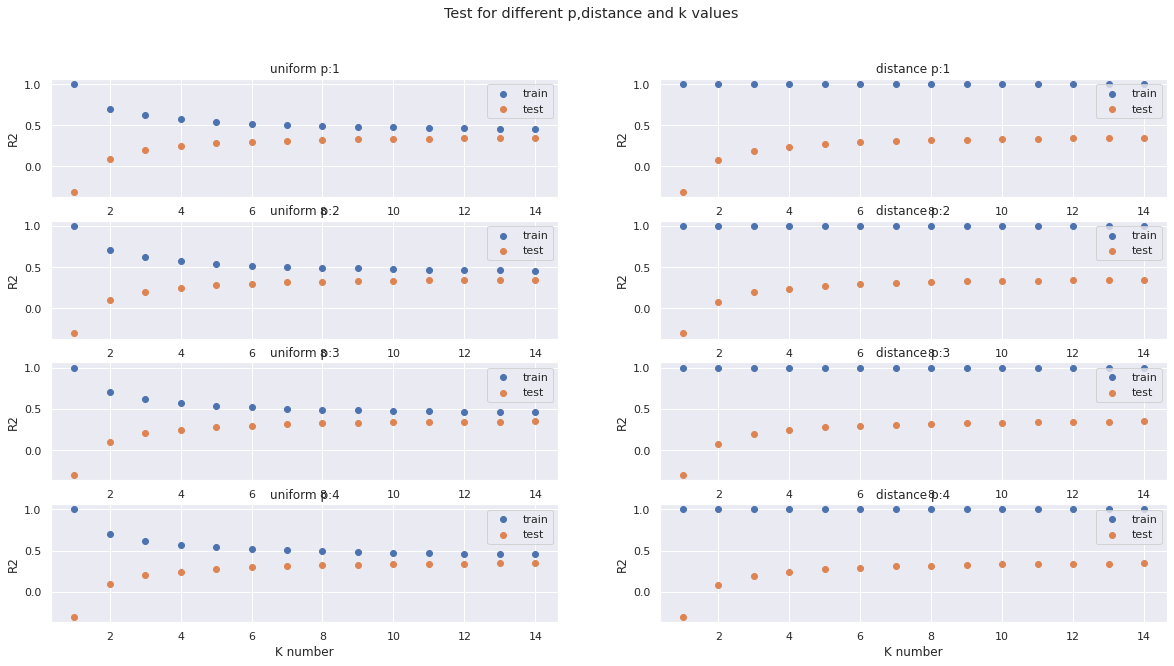

In [43]:
r2_train_test(X_normalized_train_age,X_normalized_test_age,y_train_age, y_test_age,k_max = 15)

In [44]:
# We choose the k = 15

In [113]:
from sklearn.neural_network import  MLPRegressor
mlp = MLPRegressor( max_iter = 1000)
mlp.fit(X_normalized_train_age,y_train_age)
pred = mlp.predict(X_normalized_test_age) 
r2_score(y_test_age, pred)

0.3881604575539609

In [109]:
knn = KNeighborsRegressor(n_neighbors=10 , p = 3 , weights = 'distance') 
knn.fit(X_normalized_train_age,y_train_age)
y_pred = knn.predict(X_normalized_test_age) 
r2_score(y_test_age, y_pred)

0.3329139338099112

In [46]:
 # We need to provide the indexes we stored earlier
predicted_age = pd.DataFrame(y_pred,columns=['Predicted_age'], index = rows_without_na)

In [47]:
numericals2 = pd.concat([numericals,predicted_age],axis=1)

In [48]:
numericals2[['age','Predicted_age']].tail(25)

,age,Predicted_age
10254,25.0,25.0
10255,13.0,13.0
10256,35.0,35.0
10257,NaN,NaN
10258,27.0,27.0
...,...,...
10274,NaN,NaN
10275,33.0,33.0
10276,41.0,41.0
10277,26.0,26.0


In [49]:
# Old mean
numericals2['age'].mean()

33.593778280542985

In [50]:
# New mean
numericals2['Predicted_age'].mean()

33.593778280542985

In [51]:
data_with_na = numericals2[numericals2['age'].isna()]
rows_with_na = numericals2[numericals2['age'].isna()].index
numericals_with_na = data_with_na.select_dtypes(np.number)
numericals_with_na.head()

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited,Predicted_age
37,440,0,180,63,NaN,25,1257548400,1066428000,10,68,49,68,53.40,46,534,1.911204e+07,60.70,NaN
53,552,0,177,68,NaN,25,1273269600,1124056800,20,46,46,62,48.35,31,967,7.460640e+06,55.17,NaN
71,725,0,178,73,NaN,21,1464127200,972684000,27,64,46,70,56.56,46,1527,1.820160e+07,63.28,NaN
72,733,0,190,73,NaN,25,1244325600,1210456800,2,53,51,53,52.00,51,104,1.693440e+07,52.50,NaN
78,768,0,190,73,NaN,17,1219096800,1097532000,38,49,51,59,51.95,46,1974,3.199074e+06,55.48,NaN


In [52]:
# We need to be careful to select only the columns present in the dataframe that we've used to train the model.
# In particular, the "Predicted_age" column was not there
X_age_na = numericals_with_na.drop(['user_id','age','Predicted_age','grades_max','grades_mean','grades_min','grades_sum','intensity','suited'],axis=1)

In [53]:
X_age_na

,sex,height,weight,years_cl,date_max,date_min,grades_count,grades_first,grades_last
37,0,180,63,25,1257548400,1066428000,10,68,49
53,0,177,68,25,1273269600,1124056800,20,46,46
71,0,178,73,21,1464127200,972684000,27,64,46
72,0,190,73,25,1244325600,1210456800,2,53,51
78,0,190,73,17,1219096800,1097532000,38,49,51
...,...,...,...,...,...,...,...,...,...
10259,0,180,73,2,1504476000,1501624800,6,38,40
10263,0,193,78,1,1503439200,1499551200,8,40,36
10265,0,190,88,4,1502575200,1501970400,2,46,42
10266,1,170,53,2,1501711200,1470261600,7,49,46


In [54]:
X_normalized_age_na_np = scaler.transform(X_age_na)
X_normalized_age_na_df = pd.DataFrame(X_normalized_age_na_np, columns=X_age_na.columns)
X_normalized_age_na_df

,sex,height,weight,years_cl,date_max,date_min,grades_count,grades_first,grades_last
0,0.0,0.690476,0.396552,0.685714,0.657876,0.709815,0.006098,0.887097,0.600000
1,0.0,0.654762,0.482759,0.685714,0.679597,0.748173,0.013720,0.532258,0.557143
2,0.0,0.666667,0.568966,0.571429,0.943297,0.647419,0.019055,0.822581,0.557143
3,0.0,0.809524,0.568966,0.685714,0.639607,0.805681,0.000000,0.645161,0.628571
4,0.0,0.809524,0.568966,0.457143,0.604749,0.730518,0.027439,0.580645,0.628571
...,...,...,...,...,...,...,...,...,...
1434,0.0,0.690476,0.568966,0.028571,0.999045,0.999482,0.003049,0.403226,0.471429
1435,0.0,0.845238,0.655172,0.000000,0.997612,0.998102,0.004573,0.435484,0.414286
1436,0.0,0.809524,0.827586,0.085714,0.996419,0.999712,0.000000,0.532258,0.500000
1437,1.0,0.571429,0.224138,0.028571,0.995225,0.978607,0.003811,0.580645,0.557143


In [55]:
# Now we're ready to make predictions with our model for the rows with NA's

pred_na = knn.predict(X_normalized_age_na_df)
pred_na[:5]

array([44.46185496, 44.46185496, 44.46185496, 44.46185496, 44.46185496])

In [56]:
# We create a new column to hold the final values of the age (initially filled with 0's)
numericals2['Final_age'] = 0

# Now let's replace the values of the new column with:
# The old values of age when they exist
# The predictions when age had NA's
col_final_age = list(numericals2.columns).index('Final_age')
col_age = list(numericals2.columns).index('age')
numericals2.iloc[rows_with_na, col_final_age] = pred_na
numericals2.iloc[rows_without_na, col_final_age] = numericals2.iloc[rows_without_na, col_age]
numericals2.head(20)

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited,Predicted_age,Final_age
0,4,1,165,58,33.0,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36,33.0,33.0
1,10,0,167,63,52.0,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68,52.0,52.0
2,16,0,177,68,44.0,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94,44.0,44.0
3,28,0,180,68,45.0,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77,45.0,45.0
4,38,0,178,73,35.0,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63,35.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,166,0,165,63,42.0,19,1485644400,987804000,73,55,49,57,51.14,36,3733,6.819732e+06,54.07,42.0,42.0
16,178,0,170,68,47.0,27,1434578400,1106089200,25,62,62,66,61.12,55,1528,1.313957e+07,63.56,47.0,47.0
17,190,0,177,78,35.0,20,1157061600,999554400,15,62,53,64,54.60,49,819,1.050048e+07,59.30,35.0,35.0
18,206,0,195,83,46.0,25,1192053600,1191967200,2,51,46,51,48.50,46,97,4.320000e+04,49.75,46.0,46.0


In [57]:
print("The new mean is: {:.2f}".format(numericals2['Final_age'].mean()))
print("The old mean was: {:.2f}".format(numericals2['age'].mean()))

The new mean is: 35.12
The old mean was: 33.59


In [58]:
numericals2['age'].value_counts(dropna=False)

NaN     1439
33.0     505
32.0     477
31.0     471
29.0     434
        ... 
76.0       1
66.0       1
60.0       1
1.0        1
62.0       1
Name: age, Length: 68, dtype: int64

In [59]:
# Now let's replace the age with the new FINAL_age values and drop the additional columns
numericals2['age'] = numericals2['Final_age']
numericals2.drop(['Predicted_age','Final_age'],axis=1,inplace=True)
numericals2.head()

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited
0,4,1,165,58,33.0,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36
1,10,0,167,63,52.0,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68
2,16,0,177,68,44.0,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94
3,28,0,180,68,45.0,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77
4,38,0,178,73,35.0,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63


In [60]:
numericals2['age'].value_counts(dropna=False)

33.000000    505
32.000000    477
31.000000    471
29.000000    434
35.000000    433
            ... 
44.461855      1
44.461855      1
44.461855      1
44.461855      1
44.461855      1
Name: age, Length: 1425, dtype: int64

In [61]:
numericals2

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited
0,4,1,165,58,33.000000,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36
1,10,0,167,63,52.000000,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68
2,16,0,177,68,44.000000,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94
3,28,0,180,68,45.000000,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77
4,38,0,178,73,35.000000,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,66946,0,172,78,44.461855,3,1504130400,1501538400,4,51,42,51,44.25,38,177,6.480000e+05,47.62
10275,66987,0,194,83,33.000000,5,1504735200,1430517600,8,36,40,49,41.38,36,331,9.277200e+06,45.19
10276,67009,0,165,63,41.000000,20,1504044000,1495231200,2,51,51,51,51.00,51,102,4.406400e+06,51.00
10277,67019,0,172,73,26.000000,4,1502488800,1497477600,5,44,42,44,41.00,31,205,1.002240e+06,42.50


In [62]:
climber_df = pd.concat([numericals2,categoricals], axis=1)
climber_df

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited,country,intensity_lab,suited_lab
0,4,1,165,58,33.000000,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36,SWE,HIGH,PRO
1,10,0,167,63,52.000000,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68,SWE,MEDIUM,SUITED
2,16,0,177,68,44.000000,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94,NOR,VERY HIGH,PRO
3,28,0,180,68,45.000000,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77,CAN,VERY HIGH,PRO
4,38,0,178,73,35.000000,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63,GBR,MEDIUM,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,66946,0,172,78,44.461855,3,1504130400,1501538400,4,51,42,51,44.25,38,177,6.480000e+05,47.62,BRA,LOW,NORMAL
10275,66987,0,194,83,33.000000,5,1504735200,1430517600,8,36,40,49,41.38,36,331,9.277200e+06,45.19,ESP,VERY HIGH,PRO
10276,67009,0,165,63,41.000000,20,1504044000,1495231200,2,51,51,51,51.00,51,102,4.406400e+06,51.00,other,HIGH,SUITED
10277,67019,0,172,73,26.000000,4,1502488800,1497477600,5,44,42,44,41.00,31,205,1.002240e+06,42.50,NOR,LOW,NORMAL


## Finished the KNN for Age ---------------------------_

In [63]:
climber_df.shape

(10279, 20)

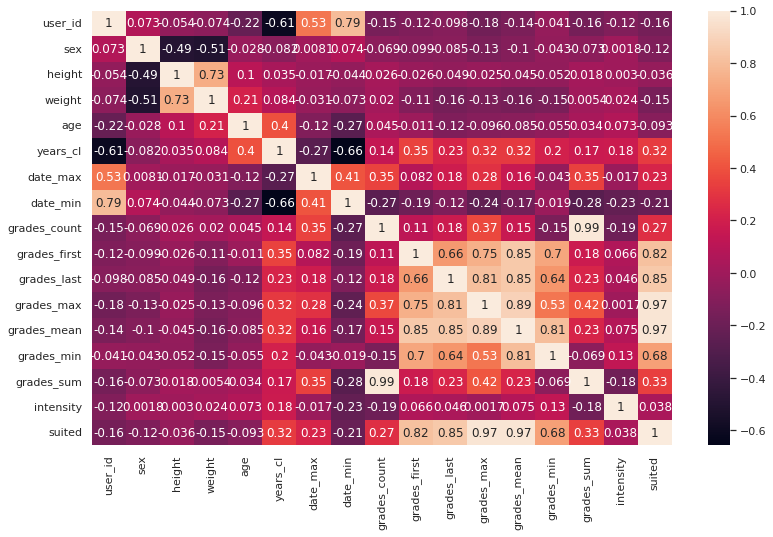

In [64]:
sns.set(rc={'figure.figsize':(13,8)})
correlations_matrix = climber_df.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [65]:
# climber_split = climber_df[['height','weight','grades_max','sex','started']]
climber_split_men = climber_df[climber_df['sex']==0]
climber_split_women = climber_df[climber_df['sex']==1]
climber_split_men.head()

,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited,country,intensity_lab,suited_lab
1,10,0,167,63,52.0,25,1499724000,801957600,216,55,51,64,45.36,7,9797,3.230400e+06,54.68,SWE,MEDIUM,SUITED
2,16,0,177,68,44.0,21,1351116000,979254000,24,62,62,64,51.88,40,1245,1.549425e+07,57.94,NOR,VERY HIGH,PRO
3,28,0,180,68,45.0,29,1503093600,649116000,80,53,57,64,49.54,29,3963,1.067472e+07,56.77,CAN,VERY HIGH,PRO
4,38,0,178,73,35.0,24,1503784800,1110236400,226,57,62,72,61.26,53,13844,1.741365e+06,66.63,GBR,MEDIUM,NORMAL
5,51,0,181,68,36.0,20,1219528800,972424800,33,59,59,64,51.21,21,1690,7.488000e+06,57.61,SWE,VERY HIGH,PRO


In [66]:
# sns.set(rc={'figure.figsize':(13,18)})
# fig, ax = plt.subplots(4,2)
# sns.lineplot(data=climber_split_men, x=climber_split_men.height, y=climber_split_men.grades_max,ax = ax[0,0])
# sns.histplot(x='height', data = climber_split_men, bins = 10, ax = ax[1,0])
# sns.lineplot(data=climber_split_men, x=climber_split_men.weight, y=climber_split_men.grades_max,ax = ax[0,1])
# sns.histplot(x='weight', data = climber_split_men, bins = 10, ax = ax[1,1])
# sns.lineplot(data=climber_split_women, x=climber_split_women.height, y=climber_split_women.grades_max,ax = ax[2,0])
# sns.histplot(x='height', data = climber_split_women, bins = 10, ax = ax[3,0])
# sns.lineplot(data=climber_split_women, x=climber_split_women.weight, y=climber_split_women.grades_max,ax = ax[2,1])
# sns.histplot(x='weight', data = climber_split_women, bins = 10, ax = ax[3,1])

In [67]:
# sns.set(rc={'figure.figsize':(13,8)})
# sns.lineplot(data=climber_split_women, x=climber_split_women.height, y=climber_split_women.weight)

<b> ------------ We have to clean the table for men and women separately: --------------

In [68]:
climber_split_women_clean = climber_split_women[climber_split_women.weight < 70]
climber_split_women_clean = climber_split_women_clean[climber_split_women_clean.height < 185]
climber_split_women_clean = climber_split_women_clean[climber_split_women_clean.height > 145]

In [69]:
climber_split_men_clean = climber_split_men[climber_split_men.weight > 45]
climber_split_men_clean = climber_split_men_clean[climber_split_men_clean.height > 155]

In [70]:
print("num of men: ", climber_split_men_clean.shape[0])
print("num of women: ",climber_split_women_clean.shape[0])

num of men:  9064
num of women:  1090


------------ Men vs Women ----------------


<AxesSubplot:xlabel='weight', ylabel='Count'>

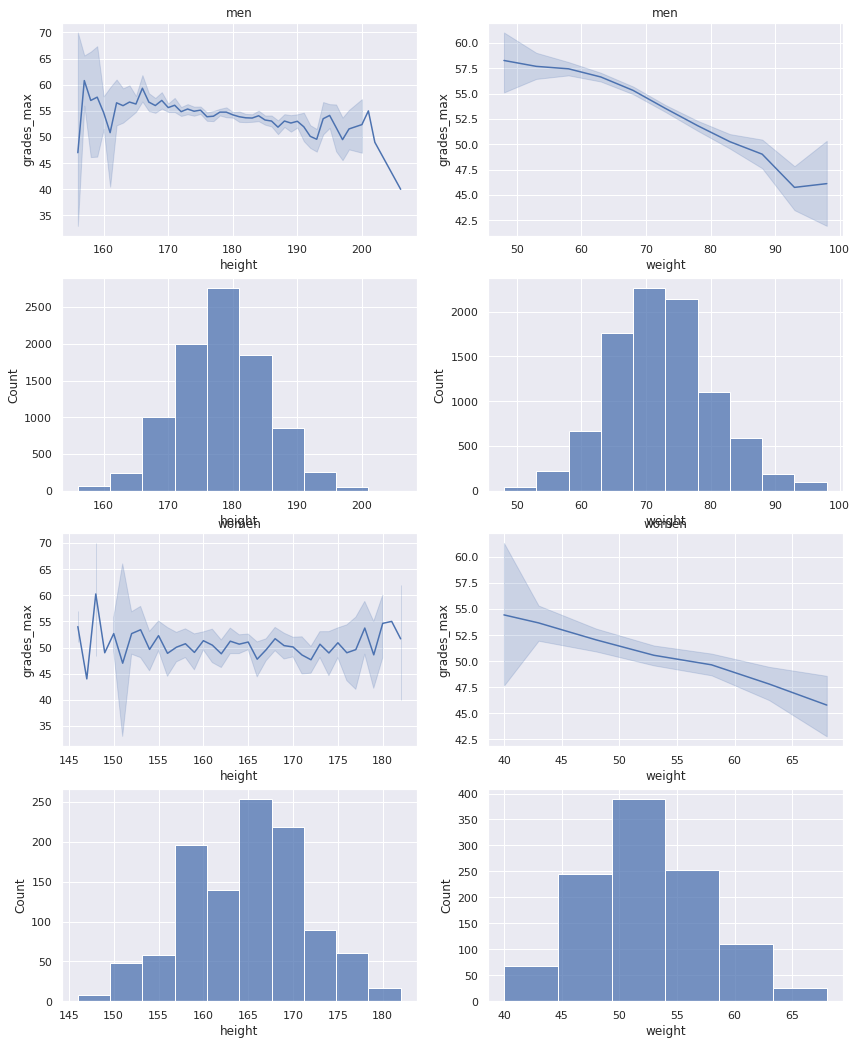

In [71]:
sns.set(rc={'figure.figsize':(14,18)})
fig, ax = plt.subplots(4,2)
print("------------ Men vs Women ----------------")
sns.lineplot(data=climber_split_men_clean, x=climber_split_men_clean.height, y=climber_split_men_clean.grades_max,ax = ax[0,0]).set_title('men')
sns.histplot(x='height', data = climber_split_men_clean, bins = 10, ax = ax[1,0])
sns.lineplot(data=climber_split_men_clean, x=climber_split_men_clean.weight, y=climber_split_men_clean.grades_max,ax = ax[0,1]).set_title('men')
sns.histplot(x='weight', data = climber_split_men_clean, bins = 10, ax = ax[1,1])
sns.lineplot(data=climber_split_women_clean, x=climber_split_women_clean.height, y=climber_split_women_clean.grades_max,ax = ax[2,0]).set_title('women')
sns.histplot(x='height', data = climber_split_women_clean, bins = 10, ax = ax[3,0])
sns.lineplot(data=climber_split_women_clean, x=climber_split_women_clean.weight, y=climber_split_women_clean.grades_max,ax = ax[2,1]).set_title('women')
sns.histplot(x='weight', data = climber_split_women_clean, bins = 6, ax = ax[3,1])

<AxesSubplot:xlabel='years_cl', ylabel='Count'>

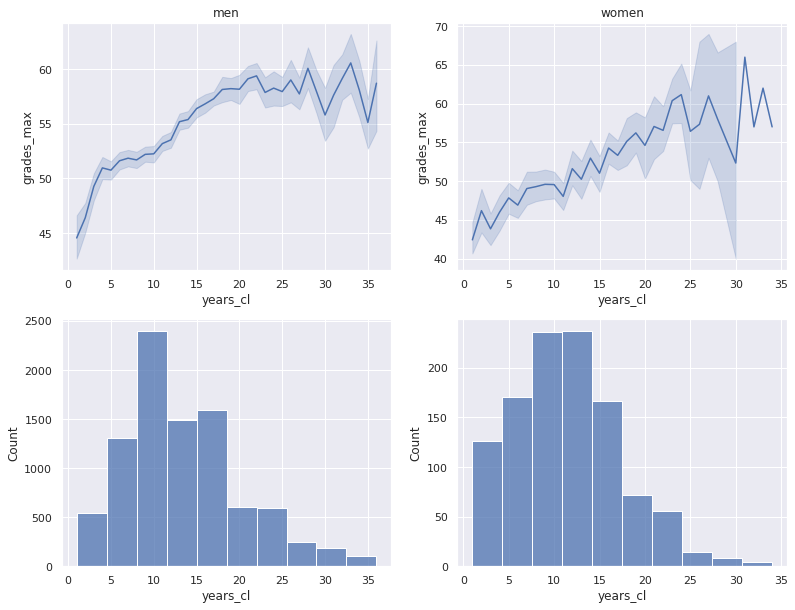

In [72]:
sns.set(rc={'figure.figsize':(13,10)})
fig, ax = plt.subplots(2,2)
sns.lineplot(data=climber_split_men_clean, x=climber_split_men_clean.years_cl, y=climber_split_men_clean.grades_max,ax = ax[0,0]).set_title('men')
sns.histplot(x='years_cl', data = climber_split_men_clean, bins = 10, ax = ax[1,0])
sns.lineplot(data=climber_split_women_clean, x=climber_split_women_clean.years_cl, y=climber_split_women_clean.grades_max,ax = ax[0,1]).set_title('women')
sns.histplot(x='years_cl', data = climber_split_women_clean, bins = 10, ax = ax[1,1])

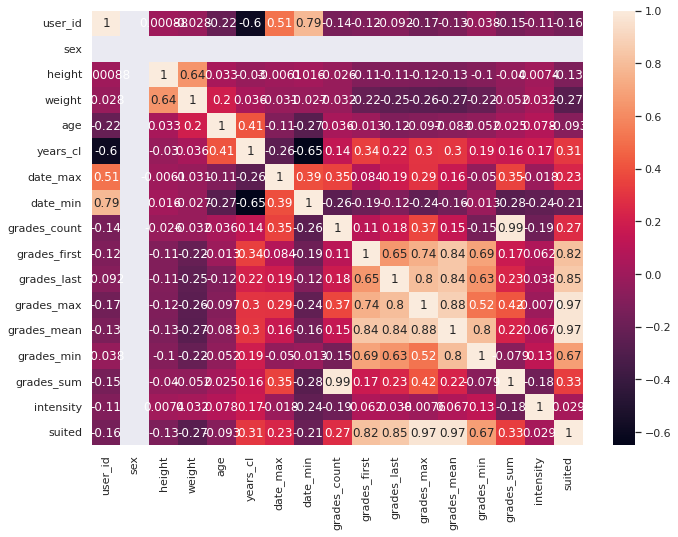

In [73]:
sns.set(rc={'figure.figsize':(11,8)})
correlations_matrix = climber_split_men_clean.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

<b> -------------------- And we concatenate them back -------------------------

In [74]:
print(climber_split_women_clean.shape)
climber_split_women_clean.head()

(1090, 20)


,user_id,sex,height,weight,age,years_cl,date_max,date_min,grades_count,grades_first,grades_last,grades_max,grades_mean,grades_min,grades_sum,intensity,suited,country,intensity_lab,suited_lab
0,4,1,165,58,33.0,16,1240783200,1155765600,15,38,51,59,53.73,38,806,5.667840e+06,56.36,SWE,HIGH,PRO
95,886,1,156,48,44.0,17,1214690400,1155333600,6,49,49,49,46.00,42,276,9.892800e+06,47.50,SWE,VERY HIGH,PRO
126,1230,1,170,53,39.0,24,1463004000,869090400,106,57,46,64,53.83,44,5706,5.602958e+06,58.91,POL,HIGH,SUITED
140,1315,1,150,48,42.0,18,1206745200,1108594800,3,53,53,55,53.67,53,161,3.271680e+07,54.34,USA,VERY HIGH,PRO
146,1353,1,161,53,34.0,2,1344031200,1000504800,128,70,40,72,53.39,13,6834,2.683800e+06,62.70,AUS,MEDIUM,SUITED


In [75]:
climber_all = pd.concat([climber_split_women_clean,climber_split_men_clean],axis=0)
climber_all.reset_index(drop = True, inplace = True )

In [117]:
climber_all.to_csv('data/climber_all_clean.csv')

# -------------------- Transformations -------------------------

In [77]:
# X,y split
X = climber_all[['country','sex','height','weight','age','years_cl','intensity_lab','suited_lab']]
y = climber_all[['grades_max']]

In [78]:
# Splitting into train set and test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [79]:
# Categorical and numerical
numerical_train = X_train.select_dtypes(include=[np.number])
numerical_test = X_test.select_dtypes(include=[np.number])
categorical_train = X_train.select_dtypes(exclude=[np.number])
categorical_test = X_test.select_dtypes(exclude=[np.number])

In [80]:
categorical_train

,country,intensity_lab,suited_lab
0,USA,VERY HIGH,PRO
1,other,HIGH,PRO
2,FRA,LOW,NORMAL
3,BEL,VERY HIGH,PRO
4,ITA,MEDIUM,SUITED
...,...,...,...
6798,USA,HIGH,SUITED
6799,CAN,HIGH,SUITED
6800,AUT,VERY HIGH,PRO
6801,ESP,MEDIUM,SUITED


In [81]:
# Categorical transformation
# 1. For the country
from sklearn.preprocessing import OneHotEncoder
column_to_encode = 'country'
country_enc = OneHotEncoder(handle_unknown='ignore')
country_enc.fit(categorical_train[[column_to_encode]])
# For the train set
onehotlabels = country_enc.transform(categorical_train[[column_to_encode]]).toarray()
categorical_train_enc = pd.DataFrame(onehotlabels,columns = country_enc.categories_[0])
# For the test set
onehotlabels = country_enc.transform(categorical_test[[column_to_encode]]).toarray()
categorical_test_enc = pd.DataFrame(onehotlabels,columns = country_enc.categories_[0])
categorical_test_enc.shape

(3351, 36)

In [82]:
# 2. For the intensity
categorical_train_enc2 = categorical_train[['intensity_lab']]
categorical_test_enc2 = categorical_test[['intensity_lab']]
mapping = {'LOW':0,'MEDIUM':1,'HIGH':2,'VERY HIGH':3}
categorical_train_enc2 = categorical_train_enc2.replace({'intensity_lab': mapping})
categorical_test_enc2 = categorical_test_enc2.replace({'intensity_lab': mapping})
categorical_train_enc2.reset_index(inplace = True, drop = True)
categorical_test_enc2.reset_index(inplace = True, drop = True)
categorical_test_enc2.shape

(3351, 1)

In [83]:
# 3. For the suited
categorical_train_enc3 = categorical_train[['suited_lab']]
categorical_test_enc3 = categorical_test[['suited_lab']]
mapping = {'NORMAL':0,'SUITED':1,'PRO':2}
categorical_train_enc3 = categorical_train_enc3.replace({'suited_lab': mapping})
categorical_test_enc3 = categorical_test_enc3.replace({'suited_lab': mapping})
categorical_train_enc3.reset_index(inplace = True, drop = True)
categorical_test_enc3.reset_index(inplace = True, drop = True)
categorical_test_enc3.shape

(3351, 1)

In [84]:
# We place all back together
X_tot_train = pd.concat([categorical_train_enc,categorical_train_enc2,categorical_train_enc3,numerical_train], axis=1) 
X_tot_test = pd.concat([categorical_test_enc,categorical_test_enc2,categorical_test_enc3,numerical_test], axis=1)

In [85]:
# Numerical transformations
from sklearn import preprocessing
numerical_transform = preprocessing.PowerTransformer().fit(X_tot_train)
# For the train set
num_train = numerical_transform.transform(X_tot_train)
X_train_trans = pd.DataFrame(num_train,columns = X_tot_train.columns)
# For the test set
num_test = numerical_transform.transform(X_tot_test)
X_test_trans = pd.DataFrame(num_test,columns = X_tot_test.columns)

In [86]:
numerical_transform = preprocessing.MinMaxScaler().fit(X_train_trans)
# For the train set
num_train = numerical_transform.transform(X_train_trans)
X_train_trans2 = pd.DataFrame(num_train,columns = X_train_trans.columns)
# For the test set
num_test = numerical_transform.transform(X_test_trans)
X_test_trans2 = pd.DataFrame(num_test,columns = X_test_trans.columns)

<AxesSubplot:xlabel='age', ylabel='Count'>

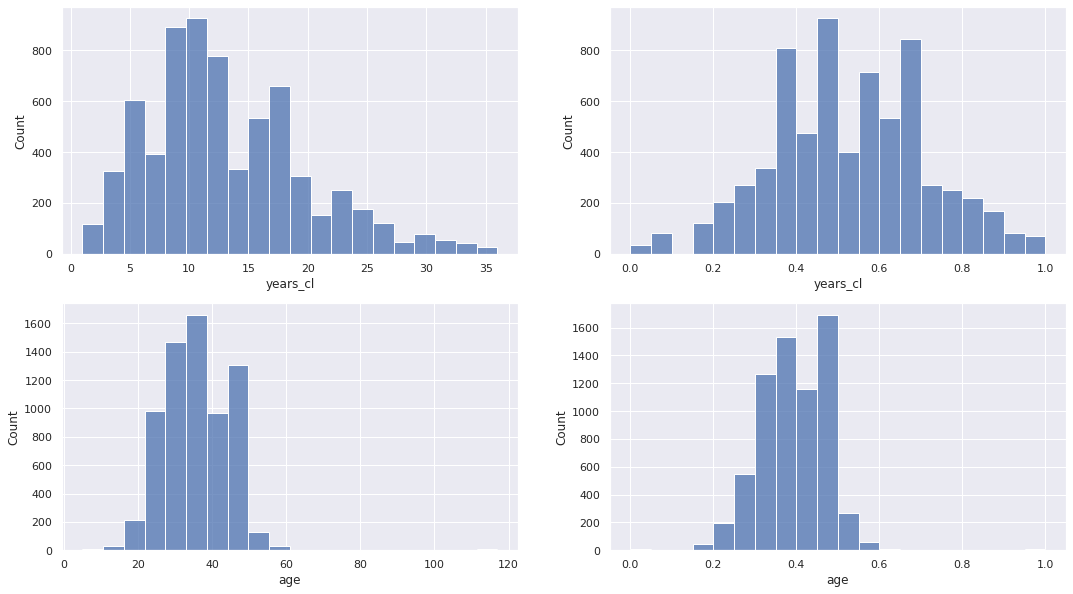

In [87]:
sns.set(rc={'figure.figsize':(18,10)})
fig, ax = plt.subplots(2,2)
sns.histplot(x='years_cl', data = X_train, bins = 20, ax = ax[0,0])
sns.histplot(x='years_cl', data = X_train_trans2, bins = 20, ax = ax[0,1])
sns.histplot(x='age', data = X_train, bins = 20, ax = ax[1,0])
sns.histplot(x='age', data = X_train_trans2, bins = 20, ax = ax[1,1])

In [88]:
X_tot_train = X_train_trans2.drop(columns=['intensity_lab'])
X_tot_test = X_test_trans2.drop(columns=['intensity_lab'])

# --------------------- Option1: Linear regression --------------------------

In [89]:
# Modeling
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_trans2, y_train)

In [90]:
# For the train set
y_pred_train = reg.predict(X_train_trans2)
# For the test set
y_pred_test = reg.predict(X_test_trans2)


In [91]:
import metrics_jor 
metrics_jor.MetricsResults(y_train, y_pred_train,y_test,y_pred_test)

,metrics,Train,Test
0,R2,0.26,0.27
1,MSE,60.54,61.31
2,RMSE,7.78,7.83
3,MAE,6.21,6.21


In [92]:
# plot_jordi.results_drawer(y_pred_train,y_train,y_pred_test,y_test)

# --------------------- Option2:  regression --------------------------

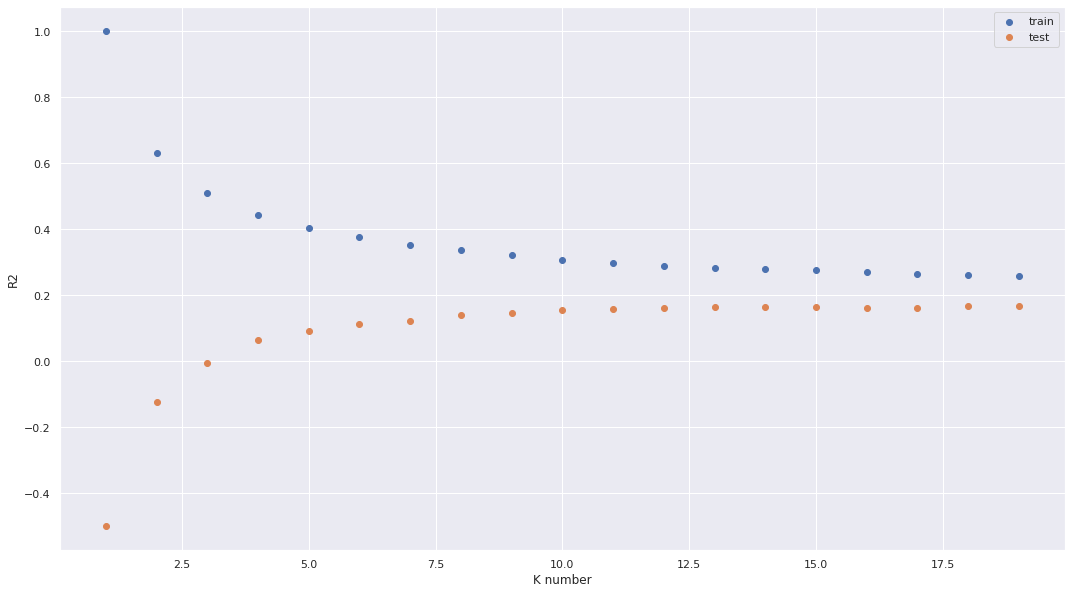

In [93]:
metrics_jor.r2_train_test(X_train_trans2,X_test_trans2,y_train, y_test,k_max = 20)

In [94]:
# K = 15 is ok

In [95]:
knn = KNeighborsRegressor(n_neighbors=15) 
knn.fit(X_train_trans2,y_train)
y_pred_test = knn.predict(X_test_trans2) 

In [96]:
metrics_jor.MetricsResults(y_train, y_pred_train,y_test,y_pred_test)

,metrics,Train,Test
0,R2,0.26,0.16
1,MSE,60.54,69.78
2,RMSE,7.78,8.35
3,MAE,6.21,6.61
